# 1. Design of a Toy metabolic network

First, one need to create a network via all the necessary package

In [88]:
%matplotlib inline
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis

model = Model('toy')

First one need to build a new metabolic network. For this one create a reaction and corresponding attributes, such as the name, localization, and default upper and lower bounds

In [89]:
reactions = dict()
for i in range(1,8):
    reactions["R"+str(i)] = Reaction("R"+str(i))
    reactions["R"+str(i)].name = "R"+str(i)
    reactions["R"+str(i)].subsystem = 'Body'
    reactions["R"+str(i)].lower_bound = 0 # default for irreversible reaction,
    reactions["R"+str(i)].upper_bound = 1000 # default
    print("Creacting R"+str(i))


Creacting R1
Creacting R2
Creacting R3
Creacting R4
Creacting R5
Creacting R6
Creacting R7


Now, we design all the metabolites

In [90]:
A = Metabolite('A', name='A', compartment='c')
B = Metabolite('B', name='B', compartment='c')
C = Metabolite('C', name='C', compartment='c')
D = Metabolite('D', name='D', compartment='c')
E = Metabolite('E', name='E', compartment='c')
F = Metabolite('F', name='F', compartment='c')

and more importantly the stoichoimetric constraints as used for each reaction

In [91]:
reactions["R1"].add_metabolites({A:-2, B:-1, C: 1})
reactions["R2"].add_metabolites({B:-1, C:-1, D: 1, E: 2})
reactions["R3"].add_metabolites({A:-4, D: 1})
reactions["R4"].add_metabolites({A:1})
reactions["R5"].add_metabolites({B:1})
reactions["R6"].add_metabolites({D: -1})
reactions["R7"].add_metabolites({E: -1})

maybe check if its working by printing reaction 2 

In [92]:
print(reactions["R2"])

R2: B + C --> D + 2 E


or all of them

In [93]:
for i in range(1,8):
    print(reactions["R"+str(i)])


R1: 2 A + B --> C
R2: B + C --> D + 2 E
R3: 4 A --> D
R4:  --> A
R5:  --> B
R6: D --> 
R7: E --> 


## Making the network more specific
Set the model by designing the upper and lower bounds for R4 

In [94]:
reactions["R4"].lower_bound = 1
reactions["R4"].upper_bound = 6

same for R7

In [95]:
reactions["R7"].lower_bound = 1
reactions["R7"].upper_bound = 4

once defined - one add all reactions to the model: here reaction by reaction

In [96]:
for i in range(1,8):
    model.add_reaction(reactions["R"+str(i)])
    

From now, you might be interested by some information about your model

In [97]:
print("Number of metabolites = ",len(model.metabolites))
print("Number of reactions = ",len(model.reactions))

Number of metabolites =  5
Number of reactions =  7


To check the model, it is always good to write a loop to get all the reactions, and their upper and lower bounds

In [98]:
for i in range(0,len(model.reactions)): 
    print(model.reactions[i],  " lb = ", model.reactions[i].lower_bound, " ub =  ", model.reactions[i].upper_bound)
    

R1: 2 A + B --> C  lb =  0  ub =   1000
R2: B + C --> D + 2 E  lb =  0  ub =   1000
R3: 4 A --> D  lb =  0  ub =   1000
R4:  --> A  lb =  1  ub =   6
R5:  --> B  lb =  0  ub =   1000
R6: D -->   lb =  0  ub =   1000
R7: E -->   lb =  1  ub =   4


# 2.Flux Balance Analysis
Now, the structure is correctly set. We are now optimizing the fluxes within the network. Again we still assume here that the system is at equilibrium: 

$$S.v = 0$$ 
s.t. $$v_i \leq u_b$$ 
and 
$$v_i \geq l_b$$

Because there is an infinity of solutions, one need optimize something. This is what one call the objective function. Roughly, one call it also the biomass function. 

To define the objectives (here maximizing $R_4$ and $R_7$), just call:

In [99]:
model.objective = {model.reactions.R4:1,model.reactions.R7:1}

And check if everything went well...

In [100]:
print('Objective of the model')
print(model.objective.expression)

Objective of the model
-1.0*R4_reverse_8717c - 1.0*R7_reverse_b9d7e + 1.0*R4 + 1.0*R7


For now, one can search for a solution that maximizes the objective function while satisfying the constraints that we already set up (i.e., $Sv=0$, and reversibility of reactions by constraining their bounds $u_b$ and $l_b$)

In [101]:
f=model.optimize()

One can print the optimal solution value and the corresponding fluxes for all reactions from the metabolic network

In [102]:
print ("optimal value=",f.f)
print ("corresponding fluxes = ")
print(f.fluxes)

optimal value= 10.0
corresponding fluxes = 
R1    2.0
R2    2.0
R3    0.5
R4    6.0
R5    4.0
R6    2.5
R7    4.0
Name: fluxes, dtype: float64


# 3. Flux Variability Analysis
Lets add here a little fuzzyness. For that we will explore the solutions arround 95% of the optimal solution. Via the use of summary, you will learn of the main feature of the model

In [103]:
model.summary(fva=0.95)

IN FLUXES               OUT FLUXES                 OBJECTIVES
----------------------  -------------------------  ------------
id      Flux  Range     id      Flux  Range        R4  6
----  ------  --------  ----  ------  -----------  R7  4
A          6  [5.5, 6]  E        4    [3.5, 4]
B          4  [3.5, 4]  D        2.5  [2.38, 2.5]


You can also check what is in the cellular compartment by emphasizing the flux variability for each reaction. For this, upload the whole cobra 

In [104]:
import cobra
fuzzy_fva = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.95)
print (fuzzy_fva)

    maximum  minimum
R1    2.000    1.750
R2    2.000    1.750
R3    0.625    0.375
R4    6.000    5.500
R5    4.000    3.500
R6    2.500    2.375
R7    4.000    3.500


# Lets play on a bigger and realistic model

In [113]:
import pandas
import cobra.test

import matplotlib.pyplot as plt

# You can use this model from the tutorial
model = cobra.test.create_test_model("ecoli")

Display some information from the model

In [122]:
print ("Number of metabolites = ",len(model.metabolites))
print ("Number of reactions = ",len(model.reactions))

Number of metabolites =  1805
Number of reactions =  2583


What is the objective of this bacteria?

In [115]:
print(model.objective)

Maximize
-1.0*Ec_biomass_iJO1366_core_53p95M_reverse_e94eb + 1.0*Ec_biomass_iJO1366_core_53p95M


Lets run a FBA

In [123]:
f=model.optimize()
print ('optimal biomass= ',f.f)

optimal biomass=  0.9823718127269693


### What the reactions that are used (i.e., not blocked)

In [117]:
for i in range(len(f.fluxes)):
    if f.fluxes[i] != 0.0:
        print (model.reactions[i])

DM_4CRSOL: 4crsol_c --> 
DM_5DRIB: 5drib_c --> 
DM_AMOB: amob_c --> 
DM_MTHTHF: mththf_c --> 
Ec_biomass_iJO1366_core_53p95M: 0.000223 10fthf_c + 2.6e-05 2fe2s_c + 0.000223 2ohph_c + 0.00026 4fe4s_c + 0.513689 ala__L_c + 0.000223 amet_c + 0.295792 arg__L_c + 0.241055 asn__L_c + 0.241055 asp__L_c + 54.124831 atp_c + 0.000122 bmocogdp_c + 2e-06 btn_c + 0.005205 ca2_c + 0.005205 cl_c + 0.000576 coa_c + 2.5e-05 cobalt2_c + 0.133508 ctp_c + 0.000709 cu2_c + 0.09158 cys__L_c + 0.026166 datp_c + 0.027017 dctp_c + 0.027017 dgtp_c + 0.026166 dttp_c + 0.000223 fad_c + 0.006715 fe2_c + 0.007808 fe3_c + 0.26316 gln__L_c + 0.26316 glu__L_c + 0.612638 gly_c + 0.215096 gtp_c + 48.601527 h2o_c + 0.094738 his__L_c + 0.290529 ile__L_c + 0.195193 k_c + 0.019456 kdo2lipid4_e + 0.450531 leu__L_c + 0.343161 lys__L_c + 0.153686 met__L_c + 0.008675 mg2_c + 0.000223 mlthf_c + 0.000691 mn2_c + 7e-06 mobd_c + 0.013894 murein5px4p_p + 0.001831 nad_c + 0.000447 nadp_c + 0.013013 nh4_c + 0.000323 ni2_c + 0.017868 p

## Study the effect of changing the amount of glucose
One will simulate the change of glucose uptake capacity. In this purpose, we must *decrease* the lower bound of the reaction that takes glucose from the environment (i.e., reaction *EX_glc_e*)

In [120]:
T = [];
for i in range(0,10):
    model.reactions.get_by_id('EX_glc_e').lower_bound= -100+i*10
    f=model.optimize()
    print(f.f)
    T.append(f.f)

9.941304113720298
8.945867191387668
7.950430269055091
6.954993346722492
5.959556424389902
4.964119502057347
3.968682579724738
2.973245657392148
1.977808735059558
0.9823718127269693


Text(0.5,0,'Glucose uptake')

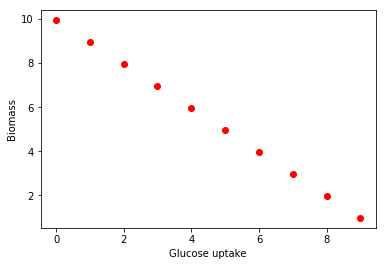

In [121]:
plt.plot(T,'or')
plt.ylabel('Biomass') 
plt.xlabel('Glucose uptake')

In [67]:
# perform a Flux Variability Analysis
fva = cobra.flux_analysis.flux_variability_analysis(model,fraction_of_optimum=1)
print (fva)

                    maximum       minimum
12DGR120tipp   1.176225e-11  0.000000e+00
12DGR140tipp   1.176225e-11  0.000000e+00
12DGR141tipp   1.176225e-11  0.000000e+00
12DGR160tipp   1.176225e-11  0.000000e+00
12DGR161tipp   1.176225e-11  0.000000e+00
12DGR180tipp   1.176225e-11  0.000000e+00
12DGR181tipp   1.176225e-11  0.000000e+00
12PPDRtex      0.000000e+00  1.189553e-12
12PPDRtpp      0.000000e+00  1.189553e-12
12PPDStex      0.000000e+00  1.170520e-12
12PPDStpp      0.000000e+00  1.170520e-12
14GLUCANabcpp  0.000000e+00  0.000000e+00
14GLUCANtexi   0.000000e+00  1.252697e-13
23CAMPtex      0.000000e+00  0.000000e+00
23CCMPtex      0.000000e+00  0.000000e+00
23CGMPtex      0.000000e+00  0.000000e+00
23CUMPtex      0.000000e+00  0.000000e+00
23DAPPAt2pp    0.000000e+00  0.000000e+00
23DAPPAtex     0.000000e+00  0.000000e+00
23PDE2pp       0.000000e+00  0.000000e+00
23PDE4pp       0.000000e+00  0.000000e+00
23PDE7pp       0.000000e+00  0.000000e+00
23PDE9pp       0.000000e+00  0.000

### Learning from the logical rules behind the reactions

In [87]:
r=model.reactions.get_by_id("TALA")
r.gene_reaction_rule

'b2464 or b0008'